In [65]:
# remember to change numbers for graph

In [66]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [67]:
tickers = ['AAPL', 'JNJ', 'JPM', 'KO', 'MMM', 'MSFT', 'PG', 'UNH', 'XOM','^GSPC']
data = yf.download(tickers, start="2000-01-01", end="2024-01-01")
print(data)

[*********************100%%**********************]  10 of 10 completed

Price        Adj Close                                                \
Ticker            AAPL         JNJ         JPM         KO        MMM   
Date                                                                   
2000-01-03    0.846127   24.698620   23.776054  14.434139  17.557297   
2000-01-04    0.774790   23.794405   23.254374  14.450142  16.859659   
2000-01-05    0.786128   24.045578   23.110825  14.578156  17.348019   
2000-01-06    0.718097   24.799088   23.438942  14.594159  18.743296   
2000-01-07    0.752113   25.854008   23.869564  15.554296  19.115364   
...                ...         ...         ...        ...        ...   
2023-12-22  193.353287  154.288544  165.409225  57.857216  87.167412   
2023-12-26  192.803986  154.963409  166.387451  58.095314  88.626625   
2023-12-27  192.903839  155.171844  167.385437  58.244122  89.143089   
2023-12-28  193.333298  155.400101  168.274734  58.283806  89.921883   
2023-12-29  192.284637  155.558899  168.077118  58.462376  89.61

In [68]:
adj_close = data['Adj Close']
print(adj_close)

Ticker            AAPL         JNJ         JPM         KO        MMM  \
Date                                                                   
2000-01-03    0.846127   24.698620   23.776054  14.434139  17.557297   
2000-01-04    0.774790   23.794405   23.254374  14.450142  16.859659   
2000-01-05    0.786128   24.045578   23.110825  14.578156  17.348019   
2000-01-06    0.718097   24.799088   23.438942  14.594159  18.743296   
2000-01-07    0.752113   25.854008   23.869564  15.554296  19.115364   
...                ...         ...         ...        ...        ...   
2023-12-22  193.353287  154.288544  165.409225  57.857216  87.167412   
2023-12-26  192.803986  154.963409  166.387451  58.095314  88.626625   
2023-12-27  192.903839  155.171844  167.385437  58.244122  89.143089   
2023-12-28  193.333298  155.400101  168.274734  58.283806  89.921883   
2023-12-29  192.284637  155.558899  168.077118  58.462376  89.618561   

Ticker            MSFT          PG         UNH         XOM     

In [69]:
def Calculate_EroD_Beta(Market_Return_Series, Stock_Return_Series):
    #daily returns
    stock_dreturns = Stock_Return_Series.pct_change()
    market_dreturns = Market_Return_Series.pct_change()

    #Uncompounded cumulative returns
    stock_ucr = stock_dreturns.cumsum()
    market_ucr = market_dreturns.cumsum()

    #Calculate 2 drawdown series
    market_drawdowns = market_ucr.cummax() - market_ucr
    stock_drawdowns = stock_ucr.cummax() - stock_ucr

    #compute and return beta (selected when drawdown exists for market first)
    threshold = market_drawdowns > 0
    market_drawdowns_selected = market_drawdowns[threshold]
    stock_drawdowns_selected = stock_drawdowns[threshold]
    beta = stock_drawdowns_selected.mean() / market_drawdowns_selected.mean()
    #return beta
    return beta

In [70]:
# Function to calculate CAPM Beta for a given window
def Calculate_CAPM_Beta(Market_Return_Series, Stock_Return_Series):
    # Calculate daily returns
    stock_returns = Stock_Return_Series.pct_change().dropna()
    market_returns = Market_Return_Series.pct_change().dropna()
    
    # Align the lengths of the return series
    common_dates = stock_returns.index.intersection(market_returns.index)
    stock_returns = stock_returns.loc[common_dates]
    market_returns = market_returns.loc[common_dates]

    # Calculate covariance between stock returns and market returns
    covariance = np.cov(stock_returns, market_returns)
    
    # The covariance between the stock and the market is the [0,1] element
    cov_stock_market = covariance[0, 1]
    
    # Calculate the variance of the market returns
    var_market = np.var(market_returns)
    
    # Beta is the ratio of covariance to variance
    beta = cov_stock_market / var_market
    return beta

In [71]:
window_size = 252
drawdown_betas = pd.DataFrame(index=adj_close.index[window_size-1:], columns=adj_close.columns)
capm_betas = pd.DataFrame(index=adj_close.index[window_size-1:], columns=adj_close.columns)

In [72]:
for ticker in adj_close.columns:
    for end_index in range(window_size - 1, len(adj_close)):
        start_index = end_index - window_size + 1
        current_date = adj_close.index[end_index]
        market_return_series = adj_close['^GSPC'][start_index:(end_index + 1)]
        stock_return_series = adj_close[ticker][start_index:(end_index + 1)]

        # Calculate and store the EroD Beta
        drawdown_betas.at[current_date, ticker] = Calculate_EroD_Beta(market_return_series, stock_return_series)
        
        # Calculate and store the CAPM Beta
        capm_betas.at[current_date, ticker] = Calculate_CAPM_Beta(market_return_series, stock_return_series)

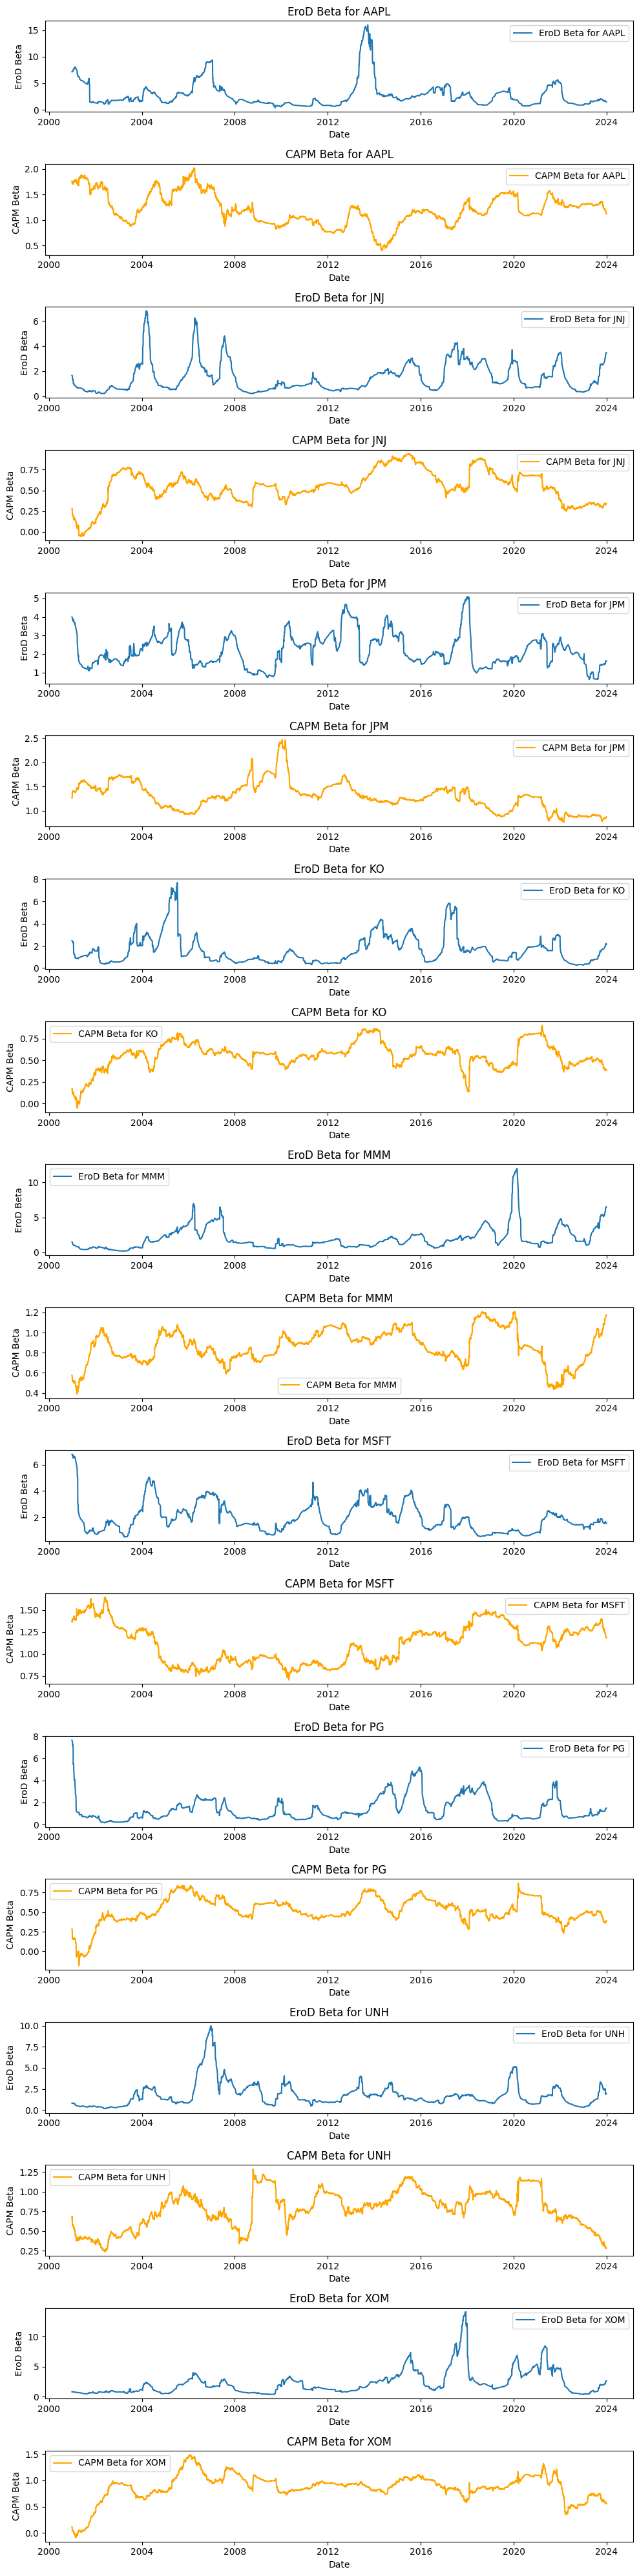

In [73]:
# Ensure you have already computed `drawdown_betas` and `capm_betas` as before.

num_stocks = 9  # The number of stocks you want to plot.
fig, axes = plt.subplots(num_stocks * 2, 1, figsize=(10, 40))  # Adjust the size as needed

for i, ticker in enumerate(drawdown_betas.columns[:num_stocks]):
    # EroD Beta subplot
    axes[i * 2].plot(drawdown_betas.index, drawdown_betas[ticker], label=f'EroD Beta for {ticker}')
    axes[i * 2].set_title(f'EroD Beta for {ticker}')
    axes[i * 2].set_xlabel('Date')
    axes[i * 2].set_ylabel('EroD Beta')
    axes[i * 2].legend()

    # CAPM Beta subplot
    axes[i * 2 + 1].plot(capm_betas.index, capm_betas[ticker], label=f'CAPM Beta for {ticker}', color='orange')
    axes[i * 2 + 1].set_title(f'CAPM Beta for {ticker}')
    axes[i * 2 + 1].set_xlabel('Date')
    axes[i * 2 + 1].set_ylabel('CAPM Beta')
    axes[i * 2 + 1].legend()

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


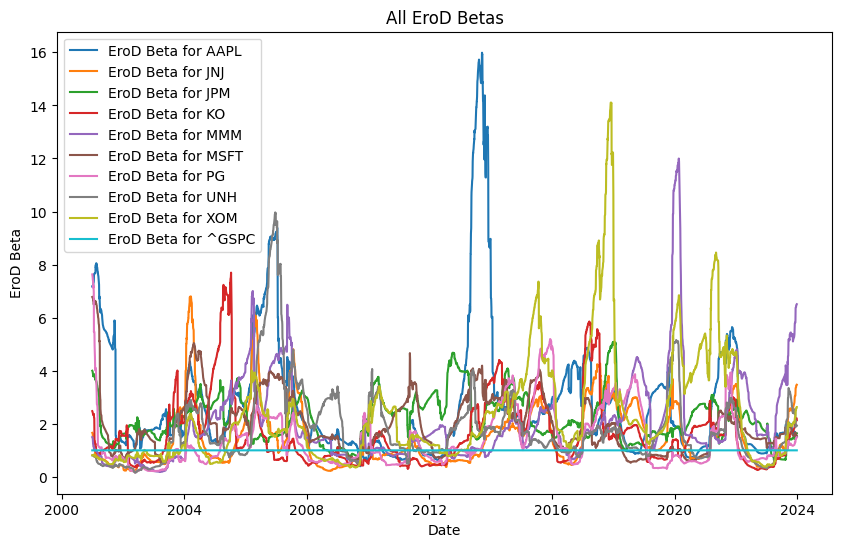

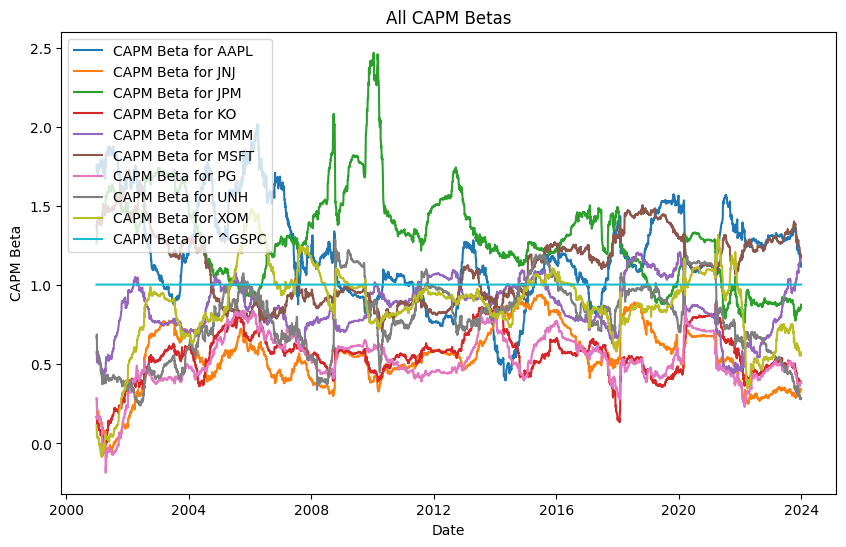

In [74]:
# Assuming 'drawdown_betas' and 'capm_betas' are already calculated as before.

# Set the number of stocks you want to plot
num_stocks = len(drawdown_betas.columns)

# Plotting all EroD Betas in one graph
fig, ax1 = plt.subplots(figsize=(10, 6))
for ticker in drawdown_betas.columns[:num_stocks]:
    ax1.plot(drawdown_betas.index, drawdown_betas[ticker], label=f'EroD Beta for {ticker}')

ax1.set_title('All EroD Betas')
ax1.set_xlabel('Date')
ax1.set_ylabel('EroD Beta')
ax1.legend(loc='upper left')  # You may need to adjust the location of the legend
plt.show()

# Plotting all CAPM Betas in one graph
fig, ax2 = plt.subplots(figsize=(10, 6))
for ticker in capm_betas.columns[:num_stocks]:
    ax2.plot(capm_betas.index, capm_betas[ticker], label=f'CAPM Beta for {ticker}')

ax2.set_title('All CAPM Betas')
ax2.set_xlabel('Date')
ax2.set_ylabel('CAPM Beta')
ax2.legend(loc='upper left')  # You may need to adjust the location of the legend
plt.show()


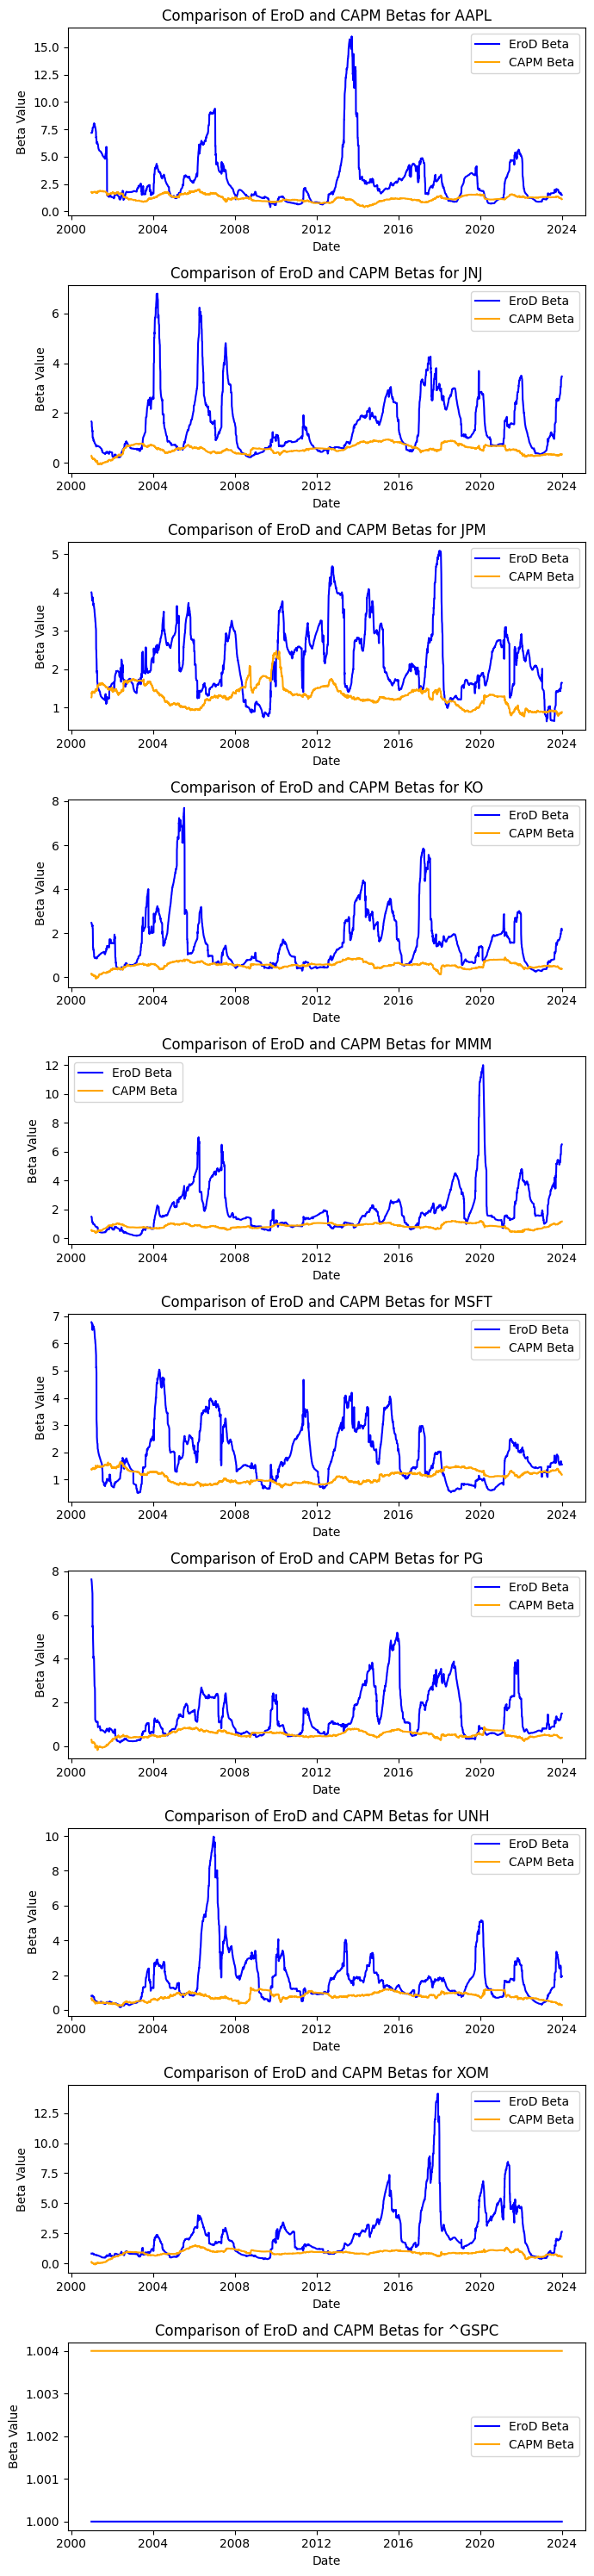

In [75]:
# Assuming 'drawdown_betas' and 'capm_betas' are already calculated as before.

num_stocks = len(drawdown_betas.columns)  # Assuming you want to plot for all stocks

# Create a figure with subplots - one for each stock
fig, axes = plt.subplots(num_stocks, 1, figsize=(7, 3 * num_stocks))

# If only one stock, axes will not be an array, so we make it into a list
if num_stocks == 1:
    axes = [axes]

# Loop through each ticker and plot both EroD and CAPM Betas on the same subplot
for i, ticker in enumerate(drawdown_betas.columns):
    # Plot EroD Beta for the current ticker
    axes[i].plot(drawdown_betas.index, drawdown_betas[ticker], label='EroD Beta', color='blue')
    
    # Plot CAPM Beta for the current ticker
    axes[i].plot(capm_betas.index, capm_betas[ticker], label='CAPM Beta', color='orange')
    
    # Set the title, labels and legend for the subplot
    axes[i].set_title(f'Comparison of EroD and CAPM Betas for {ticker}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Beta Value')
    axes[i].legend()

# Adjust the layout
plt.tight_layout()
plt.show()


In [76]:
import pandas as pd

# Calculate variance for each column in both DataFrames
capm_variances = capm_betas.var()
erod_variances = drawdown_betas.var()

# Create a DataFrame to display the variances as a table
variances_df = pd.DataFrame({
    'CAPM Beta Variance': capm_variances,
    'EroD Beta Variance': erod_variances
})

# Print the resulting DataFrame
print(variances_df)

       CAPM Beta Variance EroD Beta Variance
Ticker                                      
AAPL             0.094103           5.880929
JNJ              0.038017           1.331109
JPM              0.084197           0.750909
KO               0.022278            1.64258
MMM              0.027663           2.597611
MSFT             0.048648           1.181238
PG               0.026244           1.161085
UNH              0.053755           2.100743
XOM              0.060029           4.219792
^GSPC                 0.0                0.0
